# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    load_parquet_subset,
    perturbation_filter,
    visualize_nas,
    missing_values_filter,
)
from lib.aggregate.align import prepare_alignment_data, pca_variance_plot, embed_by_pca, tvn_on_controls
from lib.aggregate.aggregate import aggregate
from lib.aggregate.eval_aggregate import plot_feature_distributions, summarize_cell_data
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration

In [3]:
TEST_PLATE = 1
TEST_WELL = "A1"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=50000)
display(cell_data)

print("First 20 columns; use to set parameters below.")
for index, col in enumerate(cell_data.columns[:20]):
    print(index, col)

Reading first 50,000 rows from analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,429,1478.403947,1481.714474,243,254,100.607843,670.117647,...,0,0.000000,48.501317,54.812638,164.492958,0.0,0.000000,48.482563,55.773102,160.427741
1,1,A1,401,485,1477.766431,1478.877654,101,294,100.089552,669.910448,...,1,0.049751,45.269871,62.882030,106.480590,1.0,0.028818,40.760186,57.586665,116.482954
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
3,1,A1,595,475,1480.676399,1482.874696,154,221,100.764706,670.764706,...,2,0.193548,36.794933,52.151249,171.453465,2.0,0.040404,39.327858,47.072292,154.575718
4,1,A1,1479,601,1477.695030,1481.850904,365,346,99.764045,671.494382,...,0,0.000000,57.697175,61.333366,138.748450,0.0,0.000000,62.644570,63.731803,133.933684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1125,453,1480.076923,1755.965545,278,220,100.432099,168.814815,...,1,0.027778,51.719049,57.920520,168.921134,1.0,0.015625,52.825726,62.730908,168.160355
49996,1,A1,1408,731,1753.173077,1440.839744,338,2338,739.098765,92.271605,...,0,0.000000,63.654194,75.970693,59.774914,0.0,0.000000,65.328179,79.941206,91.112332
49997,1,A1,525,334,1227.967429,1592.447678,120,1347,608.121212,697.919192,...,0,0.000000,52.176829,59.403882,169.852034,0.0,0.000000,49.825625,59.247234,172.702028
49998,1,A1,56,503,1600.628225,1728.227618,19,350,130.087379,160.582524,...,0,0.000000,60.944246,69.059469,44.366065,0.0,0.000000,62.061594,64.824308,55.486461


First 20 columns; use to set parameters below.
0 plate
1 well
2 tile
3 cell_0
4 i_0
5 j_0
6 site
7 cell_1
8 i_1
9 j_1
10 distance
11 fov_distance_0
12 fov_distance_1
13 sgRNA_0
14 gene_symbol_0
15 mapped_single_gene
16 channels_min
17 nucleus_DAPI_int
18 nucleus_COXIV_int
19 nucleus_CENPA_int


## <font color='red'>SET PARAMETERS</font>

### Split cells into types

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes
- `FEATURE_START_IDX`: Index of first feature in cell data (see first 20 cols above). Usually `17`

**Note**: Any Python packages necessary for the loaded cell classifier must be imported here as well.

In [5]:
CLASSIFIER_PATH = "config/naive_mitotic_classifier.pkl"
FEATURE_START_IDX = 17

Cell class counts:
class
interphase    49538
mitotic         462
Name: count, dtype: int64
Cell class confidences:


<Axes: >

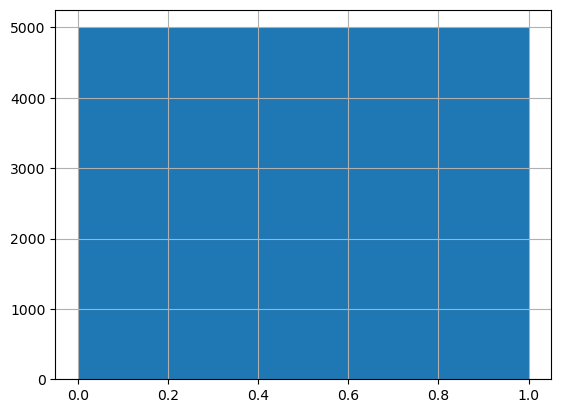

In [6]:
from sklearn.preprocessing import RobustScaler
import numpy as np
classifier = CellClassifier.load(CLASSIFIER_PATH)
classes, confidences = classifier.classify_cells(cell_data, FEATURE_START_IDX)

# Insert the arrays as new columns before the feature columns
cell_data.insert(FEATURE_START_IDX, "class", classes)
cell_data.insert(FEATURE_START_IDX + 1, "confidence", confidences)

# Update FEATURE_START_IDX
FEATURE_START_IDX += 2

# Create config var for cell classes
CELL_CLASSES = list(cell_data["class"].unique())

print("Cell class counts:")
print(cell_data["class"].value_counts())

print("Cell class confidences:")
cell_data["confidence"].hist()

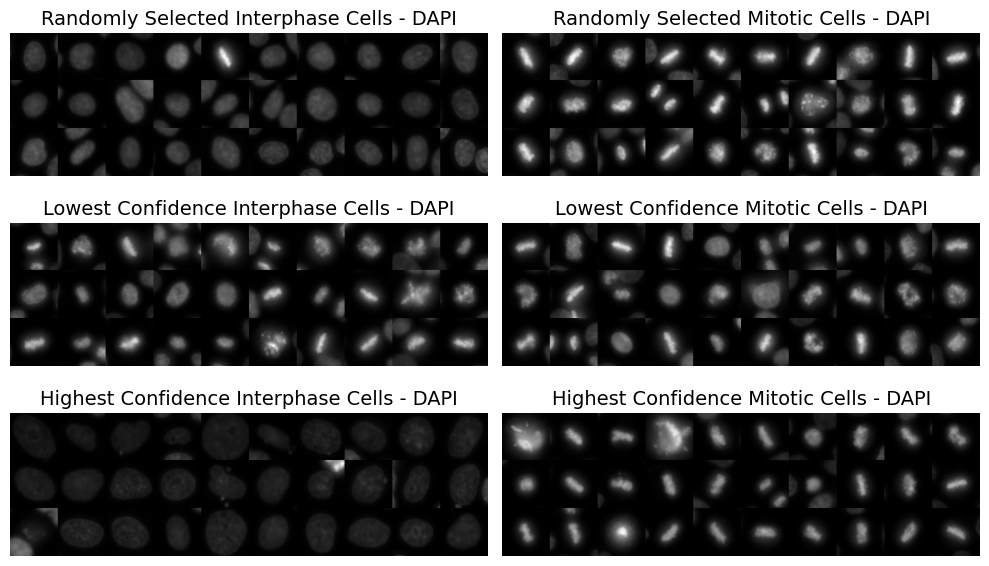

In [7]:
classified_cell_data = cell_data.copy()
classified_cell_data = add_filenames(classified_cell_data, ROOT_FP)

# Use final thresholding to split cells
mitotic_df = classified_cell_data[classified_cell_data["class"] == "mitotic"]
interphase_df = classified_cell_data[classified_cell_data["class"] == "interphase"]

# Create figure to evaluate DAPI cutoff

titles = [
    "Randomly Selected Interphase Cells - DAPI",
    "Randomly Selected Mitotic Cells - DAPI",
    "Lowest Confidence Interphase Cells - DAPI",
    "Lowest Confidence Mitotic Cells - DAPI",
    "Highest Confidence Interphase Cells - DAPI",
    "Highest Confidence Mitotic Cells - DAPI",
]

# Get channels from config
CHANNELS = config["phenotype"]["channel_names"]
montages = [
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "random",
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "random",
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": True,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": True,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": False,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": False,
        },
    )["DAPI"],
]

# Initialize figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

# Display each montage
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `PERTURBATION_NAME_COL`: Name of column used to identify perturbation
- `PERTURBATION_MULTI_COL`: Name of column that has a boolean flag for if multiple perturbations are detected
- `FILTER_SINGLE_PERT`: Whether or not to only keep cells that have a single perturbation

Found 22753 cells with assigned perturbations
Unique populations: 4601
Columns with high NA value percent:
  - cytoplasm_DAPI_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_COXIV_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_CENPA_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_WGA_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_DAPI_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_COXIV_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_CENPA_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_WGA_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_DAPI_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_COXIV_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_CENPA_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_WGA_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_DAPI_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_COXIV_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_CENPA_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_WGA_radial_cv_1: 14838 NAs (65.21%)


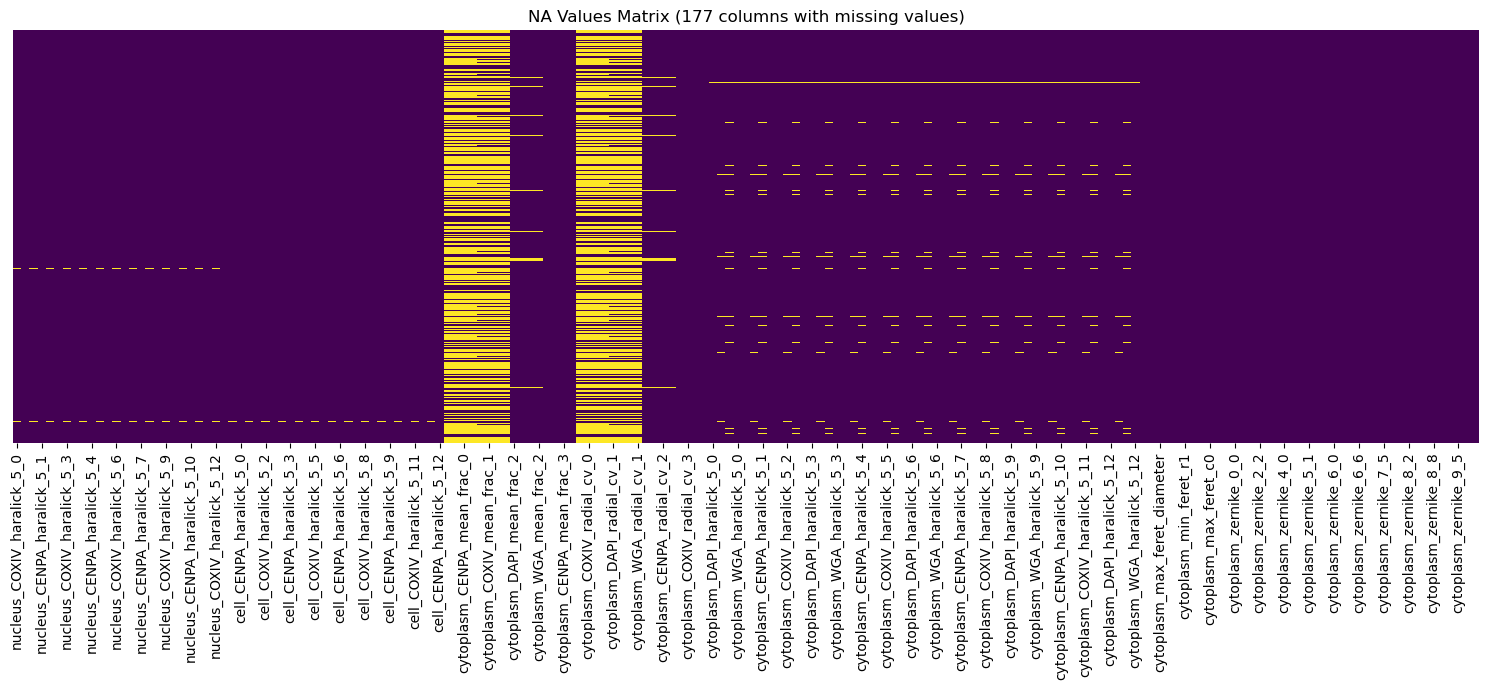

In [8]:
PERTURBATION_NAME_COL = "gene_symbol_0"
PERTURBATION_MULTI_COL = "mapped_single_gene"
FILTER_SINGLE_PERT = False

perturbation_filtered = perturbation_filter(
    cell_data, PERTURBATION_NAME_COL, PERTURBATION_MULTI_COL, FILTER_SINGLE_PERT
)
print(f"Unique populations: {perturbation_filtered[PERTURBATION_NAME_COL].nunique()}")

fig = visualize_nas(perturbation_filtered)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Missing value filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`

In [9]:
DROP_COLS_THRESHOLD = 0.1

In [10]:
# Filter by missing values
missing_values_filtered = missing_values_filter(
    perturbation_filtered, FEATURE_START_IDX, drop_cols_threshold=DROP_COLS_THRESHOLD
)

missing_values_filtered

Dropping 16 columns with ≥10.0% missing values
Imputing 161 columns with remaining missing values


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
1,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,...,0,0.000000,47.622937,66.673654,164.933186,0.0,0.000000,47.218841,73.716465,172.741491
2,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,...,0,0.000000,62.678918,63.863621,71.686607,0.0,0.000000,60.153852,68.126821,69.547069
3,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,...,0,0.000000,60.341099,60.813897,175.345937,0.0,0.000000,66.581960,67.210621,175.959281
4,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,...,1,0.153846,39.735701,56.638368,71.506693,1.0,0.088496,39.549864,55.681246,79.132618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22748,1,A1,831,511,1312.816113,1699.527675,218,154,56.640777,723.864078,...,0,0.000000,65.559405,72.844730,55.674649,0.0,0.000000,56.393234,71.543513,131.394288
22749,1,A1,1017,451,1486.380638,1204.132013,257,200,100.471154,601.057692,...,0,0.000000,45.496332,89.098660,72.976404,0.0,0.000000,34.700716,83.190703,87.296246
22750,1,A1,193,366,1545.828172,1747.975025,38,269,116.857143,736.037594,...,0,0.000000,72.856111,78.369999,33.207179,0.0,0.000000,77.124473,77.180167,38.293143
22751,1,A1,1434,397,1250.568815,1633.331742,327,3453,1185.321839,140.068966,...,0,0.000000,66.324855,71.544292,151.676972,0.0,0.000000,64.961924,67.189967,145.825952


## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`

In [11]:
BATCH_COLS = ["plate", "well"]

Number of components needed for 95.0% variance: 428
Shape of input data: (22753, 1651)
Shape of PCA transformed and reduced data: (22753, 428)
Top 10 pertubration counts:


gene_symbol_0
nontargeting    523
DCAF13           22
KLF5             22
LMAN2            21
ARPC4-TTLL3      21
ZNF286B          21
PHB              21
IREB2            21
RSL24D1          20
GOSR2            20
Name: count, dtype: Int64

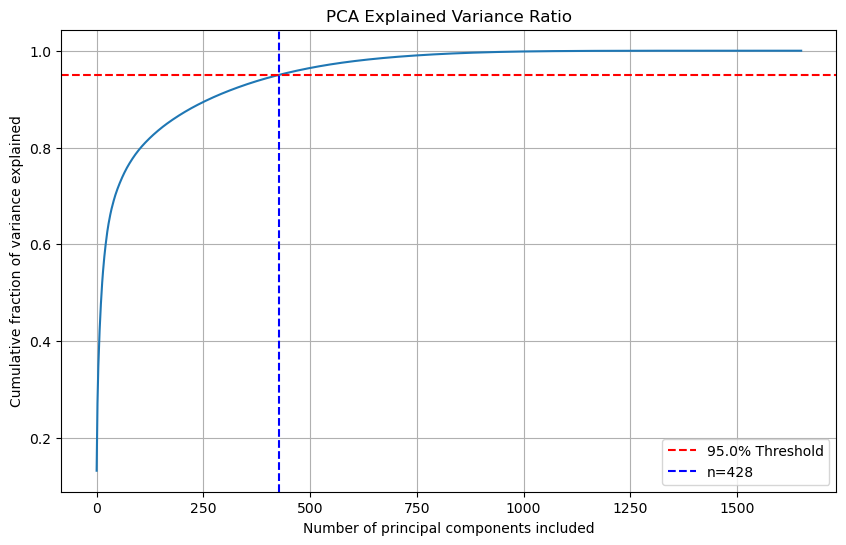

In [12]:
features, metadata = prepare_alignment_data(missing_values_filtered, BATCH_COLS, FEATURE_START_IDX)

pca_df_threshold, n_components, pca, fig = pca_variance_plot(features, variance_threshold=0.95)

print("Top 10 pertubration counts:")
metadata[PERTURBATION_NAME_COL].value_counts()[:10]

## <font color='red'>SET PARAMETERS</font>

### Align and aggregate

- `PC_COUNT`: Number of principal components to use when creating embeddings with PCA (see figure above). Usually the amount of principal components needed to explain 95% of variance (see above).
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.
- `AGG_METHOD`: Method used to aggregate features. Can be `mean` or `median`. Usually `mean`.

In [ ]:
PC_COUNT = 432
CONTROL_KEY = "nontargeting"
AGG_METHOD = "mean"

In [14]:
pca_embeddings = embed_by_pca(features.values, metadata, variance_or_ncomp=PC_COUNT, batch_col="batch_values")
tvn_normalized = tvn_on_controls(pca_embeddings, metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values")

aggregated_embeddings, aggregated_metadata = aggregate(
    tvn_normalized, metadata, PERTURBATION_NAME_COL, method=AGG_METHOD
)

feature_columns = [f'PC_{i}' for i in range(tvn_normalized.shape[1])]

tvn_normalized_df = pd.DataFrame(tvn_normalized, index=metadata.index, columns=feature_columns)
aligned_cell_data = pd.concat([metadata, tvn_normalized_df], axis=1)

aggregated_embeddings_df = pd.DataFrame(aggregated_embeddings, index=aggregated_metadata.index, columns=feature_columns)
aggregated_cell_data = pd.concat([aggregated_metadata, aggregated_embeddings_df], axis=1).sort_values("cell_count", ascending=False).reset_index(drop=True)

aggregated_cell_data

,gene_symbol_0,cell_count,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,...,PC_422,PC_423,PC_424,PC_425,PC_426,PC_427,PC_428,PC_429,PC_430,PC_431
0,nontargeting,523,9.074959e-18,9.499518e-18,6.368392e-19,-1.103855e-17,-7.854350e-18,1.188767e-17,-2.396108e-17,3.778579e-17,...,-6.071200e-17,-4.192525e-18,-5.338835e-17,-4.081078e-17,3.141740e-17,-1.910518e-17,-3.028966e-17,5.699711e-17,-5.094714e-18,-1.485958e-18
1,KLF5,22,5.027949e-02,2.458834e-02,6.701440e-02,1.822973e-01,2.599731e-02,6.362025e-04,-1.893274e-02,5.356927e-02,...,-1.481899e+00,1.342415e+00,-2.932967e+00,-1.412718e+00,6.078230e+00,-4.093658e+00,1.271301e+01,2.780021e+00,1.790063e+00,-2.488099e+00
2,DCAF13,22,5.101540e-02,-7.404537e-02,1.758709e-01,1.498793e-03,1.237166e-01,-2.296786e-01,-1.379617e-01,6.233370e-02,...,3.320814e+00,-3.583473e+00,1.300543e+01,2.596562e+00,-2.641541e-01,1.464180e+00,-1.085833e+00,-1.818156e+00,5.812649e-01,-3.606531e+00
3,IREB2,21,9.504078e-02,2.989248e-01,-9.596541e-02,-2.058165e-01,1.500942e-01,-1.681753e-01,-1.218702e-01,-2.159321e-02,...,-5.293587e+00,6.109109e+00,1.170404e+01,2.819851e+01,9.843570e+00,5.728512e+00,-1.532226e+00,6.754441e-01,2.826369e+01,8.751890e+00
4,ZNF286B,21,6.784768e-02,1.650279e-01,-3.857422e-01,-5.082701e-02,1.044243e-01,2.016853e-02,2.044335e-01,-1.010695e-01,...,-1.114381e+00,-4.088543e+00,-8.552789e-01,2.964378e+00,4.944651e+00,-1.889804e+00,6.824911e+00,2.646104e+00,2.328476e+00,6.554456e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,RTEL1,1,-1.939028e-02,-3.259240e-01,-3.867141e-01,-1.470467e-01,3.321072e-01,-1.061323e-01,-7.344079e-01,-1.848733e-01,...,-2.532592e+00,-2.506832e+00,-1.651518e+00,-3.944348e+00,5.735571e+00,1.709029e+00,1.450217e+00,-2.148468e+00,-3.077025e+00,2.226647e+00
4597,MED21,1,-2.502289e-02,3.399665e-01,4.349678e-01,-1.154445e+00,-8.624974e-01,-6.858306e-01,-1.267821e-01,1.610915e-01,...,5.848319e+01,-6.808814e+01,1.752325e+02,2.705982e+01,-7.367129e+00,3.003841e+01,9.167757e+00,1.939142e+01,2.952969e+01,-4.991486e+01
4598,E2F1,1,1.593371e-03,-2.000399e-01,8.278226e-01,4.282143e-02,6.758167e-01,6.128552e-01,-5.285705e-01,-2.246401e-01,...,3.330395e+00,1.972238e-01,3.797379e+00,-3.542756e-01,4.162520e+00,8.717798e+00,-4.304456e+00,-3.294833e+00,4.740875e+00,-1.744294e+00
4599,TNFRSF12A,1,6.271195e-02,-4.974879e-01,1.838837e-01,6.449388e-01,6.921439e-01,3.108461e-01,-3.992348e-01,-3.891532e-02,...,-3.204796e+00,-2.450656e+00,-6.563183e-01,1.306138e+00,2.003145e-01,4.034724e+00,6.235423e+00,6.075389e+00,-2.984457e+00,2.201432e+00


## <font color='red'>SET PARAMETERS</font>

### Evaluate

- `COLLAPSE_COLS`: Columns to collapse on when creating a summary of cell counts.

In [15]:
COLLAPSE_COLS = ["sgRNA_0", "gene_symbol_0"]

Aligned feature distribtutions:


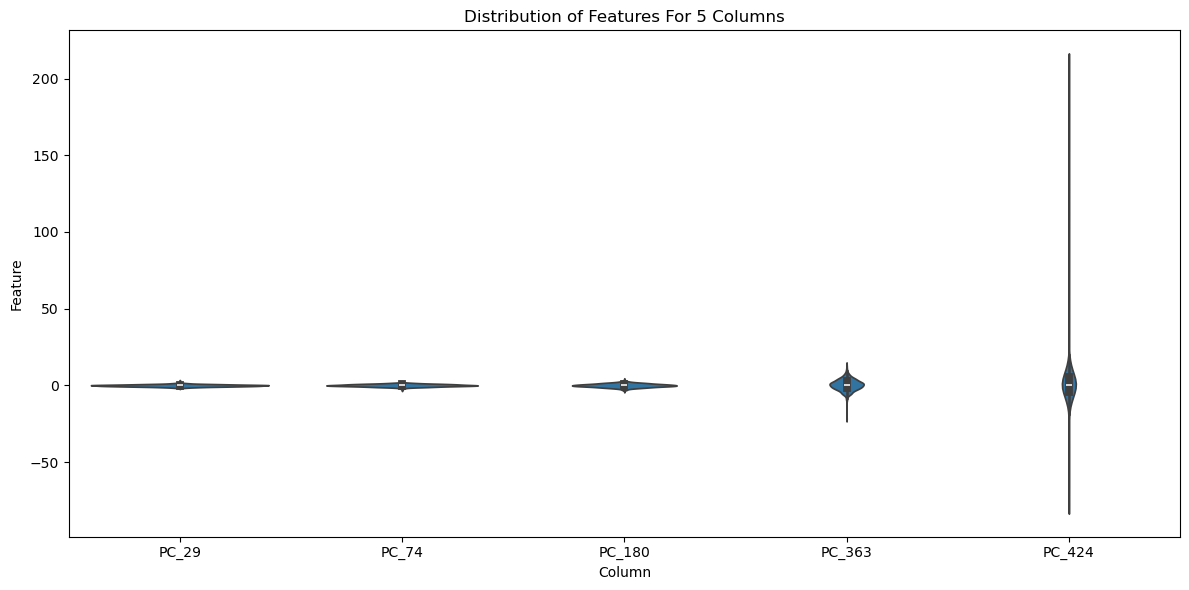

Aligned cell data summary:


,Stage,Count
0,Raw Data,22753
1,interphase Cells,22624
2,interphase sgRNA_0s,9544
3,interphase gene_symbol_0s,4595
4,mitotic Cells,129
5,mitotic sgRNA_0s,125
6,mitotic gene_symbol_0s,125


In [16]:
print("Aligned feature distribtutions:")
plot_feature_distributions(aligned_cell_data, FEATURE_START_IDX, num_features=5)

print("Aligned cell data summary:")
summary_df = summarize_cell_data(aligned_cell_data, CELL_CLASSES, COLLAPSE_COLS)
summary_df

## Add aggregate parameters to config file

In [17]:
# Add aggregate section
config["aggregate"] = {
    "classifier_path": CLASSIFIER_PATH,
    "feature_start_idx": FEATURE_START_IDX,
    "cell_classes": CELL_CLASSES,
    "perturbation_name_col": PERTURBATION_NAME_COL,
    "perturbation_multi_col": PERTURBATION_MULTI_COL,
    "filter_single_pert": FILTER_SINGLE_PERT,
    "drop_cols_threshold": DROP_COLS_THRESHOLD,
    "batch_cols": BATCH_COLS,
    "pc_count": PC_COUNT,
    "control_key": CONTROL_KEY,
    "agg_method": AGG_METHOD,
    "collapse_cols": COLLAPSE_COLS,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)